## MNIST CNN
* Building a CNN from scratch for MNIST

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/trondheim/.fastai/data/mnist_png/models'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L') # converts images from black and white

In [6]:
il.items[0]

PosixPath('/home/trondheim/.fastai/data/mnist_png/training/4/24543.png')

In [7]:
defaults.cmap='binary' # sets the default colormap to binary. 

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/trondheim/.fastai/data/mnist_png

* Our image item list contains 70,000 items, and it's a bunch of images that are 1 by 28 by 28. 
* Remember that PyTorch puts channel first, so they are one channel 28x28. You might think why aren't there just 28 by 28 matrices rather than a 1 by 28 by 28 rank 3 tensor. 
* All the Conv2d stuff and so forth works on rank 3 tensors, so you want to include that unit axis at the start, so fast.ai will do that for you even when it's reading one channel images.

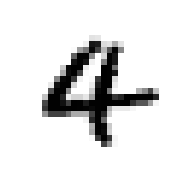

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/trondheim/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/trondheim/.fastai/data/mnist_png;

Test: None

Once you've got an image item list, you then split it into training versus validation. You nearly always want validation. If you don't, you can actually use the `.no_split` method to create an empty validation set. You can't skip it entirely. You have to say how to split, and one of the options is `no_split`. 

In [12]:
(path/'training').ls()

[PosixPath('/home/trondheim/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/trondheim/.fastai/data/mnist_png/training/1')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /home/trondheim/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /home/trondheim/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

4 torch.Size([1, 28, 28])


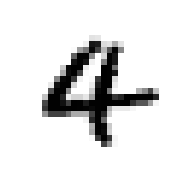

In [16]:
x.show()
print(y,x.shape)

Next thing we can do is to add transforms. 
* In this case, we're not going to use the normal `get_transforms` function because we're doing digit recognition and digit recognition, you wouldn't want to flip it left right. That would change the meaning of it. 
* You wouldn't want to rotate it too much, that would change the meaning of it.  
* Also because these images are so small, doing zooms and stuff is going to make them so fuzzy as to be unreadable. So normally, for small images of digits like this, you just add a bit of random padding. 

So I'll use the random padding function which actually returns two transforms; the bit that does the padding and the bit that does the random crop. So you have to use star(`*`) to say put both these transforms in this list.


In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
print(tfms)

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)], [])


In [18]:
ll = ll.transform(tfms)

In [19]:
bs = 128

In [20]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [21]:
x,y = data.train_ds[0]

4


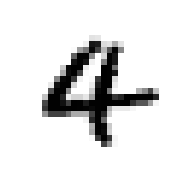

In [22]:
x.show()
print(y)

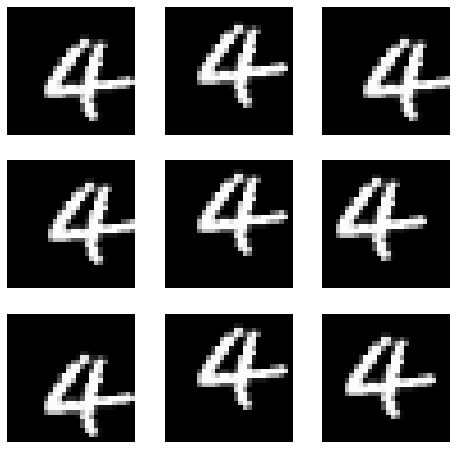

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
# plot multi plots when calling an function
plot_multi(_plot, 3, 3, figsize=(8,8))

You can always grab a batch of data then from the data bunch, because remember, data bunch has data loaders, and data loaders are things you grab a batch at a time. So you can then grab a X batch and a Y batch, look at their shape - batch size by channel by row by column:

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

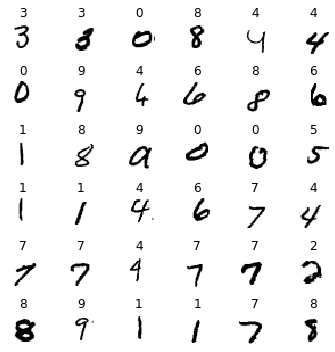

In [25]:
data.show_batch(rows=6, figsize=(5,5))

### Basic CNN with batchnorm

Let's start out creating a simple CNN. The input is 28 by 28. 
* I like to define when I'm creating architectures a function which kind of does the things that I do again and again and again. 
I don't want to call it with the same arguments because I'll forget or I make a mistake. 

In this case, all of my convolution is going to be kernel size 3 stride 2 padding 1. So let's just create a simple function to do a conv with those parameters:

In [26]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

Each time you have a convolution, it's skipping over one pixel so it's jumping two steps each time. That means that each time we have a convolution, it's going to halve the grid size. I've put a comment here showing what the new grid size is after each one.

In [27]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

Remember, you always get to pick how many filters you create regardless of whether it's a fully connected layer in which case it's just the width of the matrix you're multiplying by, or in this case with the 2D conv, it's just how many filters do you want. So I picked 8 and so after this, it's stride 2 to so the 28 by 28 image is now a 14 by 14 feature map with 8 channels. Specifically therefore, it's an 8 by 14 by 14 tensor of activations.

Then we'll do a batch norm, then we'll do ReLU. The number of input filters to the next conv has to equal the number of output filters from the previous conv, and we can just keep increasing the number of channels because we're doing stride 2, it's got to keep decreasing the grid size. Notice here, it goes from 7 to 4 because if you're doing a stride 2 conv over 7, it's going to be  `math.ceiling` of 7/2. 

Batch norm, ReLU, conv. We are now down to 2 by 2. Batch norm, ReLU, conv, we're now down to 1 by 1. 

After this, we have a feature map of 10 by 1 by 1. Does that make sense? We've got a grid size of one now. It's not a vector of length 10, it's a rank 3 tensor of 10 by 1 by 1. Our loss functions expect (generally) a vector not a rank 3 tensor, so you can chuck `flatten` at the end, and flatten just means remove any unit axes. So that will make it now just a vector of length 10 which is what we always expect.

That's how we can create a CNN. Then we can return that into a learner by passing in the data and the model and the loss function and optionally some metrics. We're going to use cross-entropy as usual. We can then call `learn.summary()` and confirm.

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [30]:
xb = xb.cuda()

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


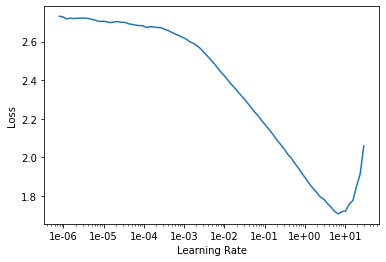

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.232865,0.202624,0.932000,00:06
1,0.137027,0.091039,0.971100,00:05
2,0.076505,0.042156,0.986500,00:05


### Refactor

Let's refactor that a little. Rather than saying conv, batch norm, ReLU all the time, fast.ai already has something called conv_layer which lets you create conv, batch norm, ReLU combinations. It has various other options to do other tweaks to it, but the basic version is just exactly what I just showed you. So we can refactor that like so:

In [35]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [36]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [37]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.227304,0.152617,0.952900,00:06
1,0.185127,0.226386,0.925500,00:04
2,0.160907,0.558000,0.826700,00:05
3,0.140595,0.173610,0.944600,00:04
4,0.114582,0.071145,0.977200,00:05
5,0.100682,0.066167,0.979400,00:06
6,0.069266,0.059488,0.981300,00:04
7,0.063968,0.040147,0.987200,00:05
8,0.052358,0.033155,0.989600,00:05
9,0.045781,0.029059,0.990200,00:05


### Resnet-ish

How can we improve this? 

What we really want to do is create a deeper network, and so a very easy way to create a deeper network would be after every stride 2 conv, add a stride 1 conv. Because the stride 1 conv doesn't change the feature map size at all, so you can add as many as you like. But there's a problem. The problem was pointed out in this paper, very very very influential paper, called [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) by Kaiming He and colleagues at (then) Microsoft Research.

They did something interesting. They said let's look at the training error. So forget generalization even, let's just look at the training error of a network trained on CIFAR-10 and let's try one network of 20 layers just basic 3x3 convs - basically the same network I just showed you, but without batch norm. They trained a 20 layer one and a 56 layer one on the training set. 

The 56 layer one has a lot more parameters. It's got a lot more of these stride 1 convs in the middle. So the one with more parameters should seriously over fit, right? So you would expect the 56 layer one to zip down to zero-ish training error pretty quickly and that is not what happens. It is worse than the shallower network.

![](images/7.png)

When you see something weird happen, really good researchers don't go "oh no, it's not working" they go "that's interesting." So Kaiming He said "that's interesting. What's going on?" and he said "I don't know, but what I do know is this - I could take this 56 layer network and make a new version of it which is identical but has to be at least as good as the 20 layer network and here's how:

![](images/8.png)

Every to convolutions, I'm going to add together the input to those two convolutions with the result of those two convolutions." In other words, he's saying instead of saying:

<img src="https://latex.codecogs.com/gif.latex?Output=Conv2(Conv1(x))" title="Output=Conv2(Conv1(x))" />

Instead, he's saying:

<img src="https://latex.codecogs.com/gif.latex?Output=x&plus;Conv2(Conv1(x))" title="Output=x+Conv2(Conv1(x))" />

His theory was 56 layers worth of convolutions in that has to be at least good as the 20 layer version because it could always just set conv2 and conv1 to a bunch of 0 weights for everything except for the first 20 layers because the X (i.e. the input) could just go straight through. So this thing here is (as you see) called an **identity connection**. It's the identity function - nothing happens at all. It's also known as a **skip connection**. 

So that was the theory. That's what the paper describes as the intuition behind this is what would happen if we created something which has to train at least as well as a 20 layer neural network because it kind of contains that 20 layer neural network. There's literally a path you can just skip over all the convolutions. So what happens? 

What happened was he won ImageNet that year. He easily won ImageNet that year. In fact, even today, we had that record-breaking result on ImageNet speed training ourselves in the last year, we used this too. ResNet has been revolutionary. 

Here's a trick if you're interested in doing some research. Anytime you find some model for anything whether it's medical image segmentation or some kind of GAN or whatever and it was written a couple of years ago, they might have forgotten to put ResBlocks in. Figure 2 is what we normally call a ResBlock. They might have forgotten to put ResBlocks in. So replace their convolutional path with a bunch of ResBlocks and you will almost always get better results faster. It's a good trick.

![](images/9.png)

In [39]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [40]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [41]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [42]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

Keep refactoring your architectures if you're trying novel architectures because you'll make less mistakes. Very few people do this. Most research code you look at is clunky as all heck and people often make mistakes in that way, so don't do that. You're all coders, so use your coding skills to make life easier

In [43]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


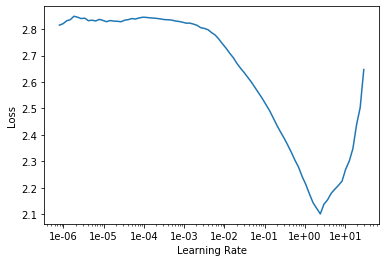

In [45]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.195928,0.111873,0.970100,00:08
1,0.130333,0.226257,0.928200,00:08
2,0.104148,0.141898,0.951500,00:07
3,0.078255,0.268249,0.913500,00:09
4,0.075177,0.097045,0.971000,00:07
5,0.061779,0.069867,0.979300,00:08
6,0.052476,0.070156,0.978900,00:08
7,0.045853,0.028771,0.991200,00:08
8,0.029811,0.027952,0.991100,00:08
9,0.027639,0.018867,0.994000,00:08


That's interesting because we've trained this literally from scratch with an architecture we built from scratch, I didn't look out this architecture anywhere. It's just the first thing that came to mind. But in terms of where that puts us, 0.45% error is around about the state of the art for this data set as of three or four years ago.

In [47]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

There's something else here which is when you create your MergeLayer, you can optionally set dense=True, and what happens if you do? Well, if you do, it doesn't go x+x.orig, it goes cat([x,x.orig]). In other words, rather than putting a plus in this connection, it does a concatenate. That's pretty interesting because what happens is that you have your input coming in to your Res block, and once you use concatenate instead of plus, it's not called a Res block anymore, it's called a dense block. And it's not called a ResNet anymore, it's called a DenseNet.

* These tend to work very good with small datasets

# UNet

* One of the main reasons other than the fact that ResNets are awesome to tell you about them is that these skipped connections are useful in other places as well. 
* They are particularly useful in other places in other ways of designing architectures for segmentation. 
* Let's rebuild UNET with access to some modern techniques

What we're going to do to get there is we're going to use this U-Net. We've used a U-Net before. We used it when we did the CamVid segmentation but we didn't understand what it was doing. So we're now in a position where we can understand what it was doing. The first thing we need to do is to understand the basic idea of how you can do segmentation. If we go back to our [CamVid notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb), in our CamVid notebook you'll remember that basically what we were doing is we were taking these photos and adding a class to every single pixel. 

## Image segmentation with CamVid

In [48]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [50]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/trondheim/.fastai/data/camvid/labels'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images'),
 PosixPath('/home/trondheim/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/trondheim/.fastai/data/camvid/codes.txt')]

In [51]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [52]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/trondheim/.fastai/data/camvid/images/0016E5_08430.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images/Seq05VD_f00780.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images/0001TP_008850.png')]

In [53]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f04590_P.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f04080_P.png')]

In [54]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

(array([720, 960]), tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

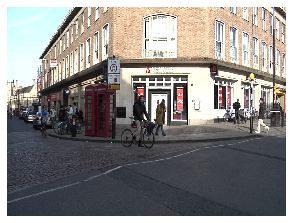

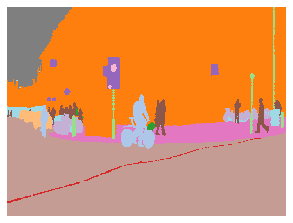

In [62]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
src_size,mask.data

In [63]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [64]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 14030MB of GPU RAM free


In [65]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [66]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

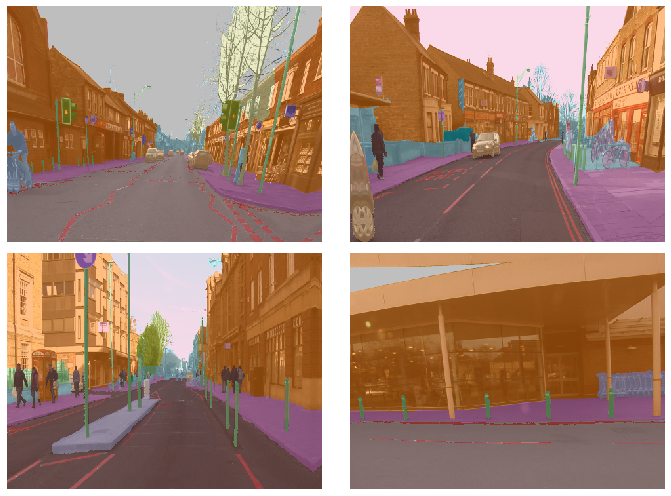

In [67]:
data.show_batch(2, figsize=(10,7))

In [68]:
bs,size = 8,src_size//2

## Model

In [69]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [70]:
metrics=acc_camvid
# metrics=accuracy

In [71]:
wd=1e-2

In [72]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

![](images/16.png)

In [73]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________

So that's what the U-Net's downsampling path (the left half is called the downsampling path) look like. Ours is just a ResNet 34. So you can see it here `learn.summary()`, this is literally a ResNet 34. So you can see that the size keeps halving, channels keep going up and so forth.

Eventually, you've got down to a point where, if you use U-Net architecture, it's 28 by 28 with 1,024 channels. With the ResNet architecture with a 224 pixel input, it would be 512 channels by 7 by 7. 

So it's a pretty small grid size on this feature map. Somehow, we've got to end up with something which is the same size as our original picture. 

So how do we do that? How do you do computation which increases the grid size? Well, we don't have a way to do that in our current bag of tricks. We can use a stride one conv to do computation and keeps grid size or a stride 2 conv to do computation and halve the grid size.

So how do we double the grid size? We do a **stride half conv**, also known as a **deconvolution**, also known as a **transpose convolution**.

![](images/17.png)

* This is clearly not the best stratagy for upconvolution because most of the information is empty

![](images/19.png)

That gives us our upsampling path. That lets us go from 28 by 28 to 54 by 54 and keep on doubling the size, so that's good. And that was it until U-Net came along. That's what people did and it didn't work real well which is not surprising because like in this 28 by 28 feature map, how the heck is it going to have enough information to reconstruct a 572 by 572 output space? That's a really tough ask. So you tended to end up with these things that lack fine detail.

So what Olaf Ronneberger et al. did was they said hey let's add a skip connection, an identity connection, and amazingly enough, this was before ResNets existed. So this was like a really big leap, really impressive. But rather than adding a skip connection that skipped every two convolutions, they added skip connections where these gray lines are. 

Okay, so that's U-Net and it's amazing to think it preceded ResNet, preceded DenseNet. It wasn't even published in a major machine learning venue. It was actually published in MICCAI which is a specialized medical image computing conference. For years, it was largely unknown outside of the medical imaging community. Actually, what happened was Kaggle competitions for segmentation kept on being easily won by people using U-Nets and that was the first time I saw it getting noticed outside the medical imaging community. Then gradually, a few people in the academic machine learning community started noticing, and now everybody loves U-Net, which I'm glad because it's just awesome.

# Image restoration

The next task I want to look at is image restoration. Image restoration refers to starting with an image and this time we're not going to create a segmentation mask but we're going to try and create a better image. There's lots of kind of versions of better - there could be different image. The kind of things we can do with this kind of image generation would be:

- take a low res image make it high res 
- take a black-and-white image make a color 
- take an image where something's being cut out of it and trying to replace the cutout thing 
- take a photo and try and turn it into what looks like a line drawing 
- take a photo and try and talk like it look like a Monet painting 

These are all examples of image to image generation tasks which you'll know how to do after this part class. 

So in our case, we're going to try to do image restoration which is going to start with low resolution, poor quality JPEGs, with writing written over the top of them, and get them to replace them with high resolution, good quality pictures in which the text has been removed.

In order to create something which can turn crappy images into nice images, we needed dataset containing nice versions of images and crappy versions of the same images. The easiest way to do that is to start with some nice images and "crappify" them.

## Pretrained GAN

In [83]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [84]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [85]:
from crappify import *

Uncomment the first time you run this notebook.

In [86]:
#il = ImageList.from_folder(path_hr)
#parallel(crappifier(path_lr, path_hr), il.items)

The way to crappify them is to create a function called crappify which contains your crappification logic. My crappification logic, you can pick your own, is that:

- I open up my nice image
- I resize it to be really small 96 by 96 pixels with bilinear interpolation
- I then pick a random number between 10 and 70
- I draw that number into my image at some random location
- Then I save that image with a JPEG quality of that random number. 

A JPEG quality of 10 is like absolute rubbish, a JPEG a quality of 70 is not bad at all. So I end up with high quality images and low quality images that look something like these:

For gradual resizing we can change the commented line here.

In [87]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [88]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [89]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [90]:
data_gen = get_data(bs,size)

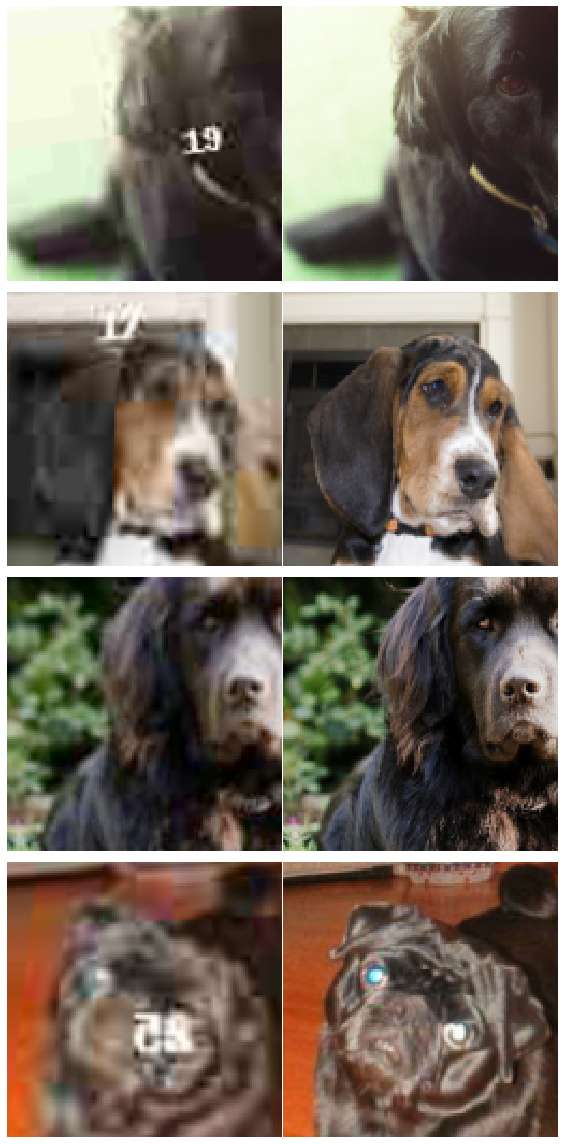

In [91]:
data_gen.show_batch(4)

In [92]:
wd = 1e-3

In [93]:
y_range = (-3.,3.)

In [94]:
loss_gen = MSELossFlat() # just flattens the image into long vectors

In [95]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [96]:
learn_gen = create_gen_learner()

So we created our U-Net with that data, the architecture is ResNet 34. These three things (`blur`, `norm_type`, `self_attention`) are important and interesting and useful, but we don't have time to discus this. For now, you should always include them when you use U-Net for this kind of problem. 

In [97]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.062825,0.055418,00:43
1,0.052691,0.049513,00:38


We're already down to 0.05 mean squared error on the pixel values which is not bad after 1 minute 35. Like all things in fast.ai pretty much, because we're doing transfer learning by default when you create this, it'll freeze the the pre-trained part. And the pre-trained part of a U-Net is the downsampling part. That's where the ResNet is.

In [98]:
learn_gen.unfreeze()

In [99]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.051383,0.050684,00:44
1,0.048587,0.046373,00:39
2,0.046236,0.045706,00:42


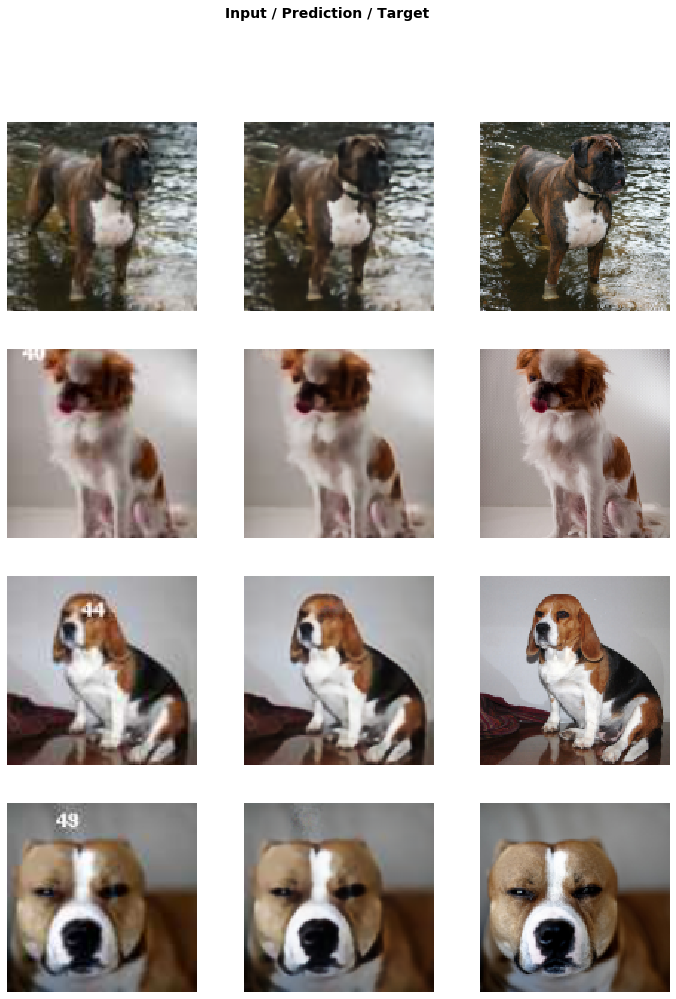

In [100]:
learn_gen.show_results(rows=4)

In [102]:
learn_gen.save('gen-pre2')

We're not finished because we actually want this thing (middle) to look more like this thing (right). 

* So how are we going to do that? The reason that we're not making as much progress with that as we'd like is that our loss function doesn't really describe what we want. 

* Because actually, the mean squared error between the pixels of this (middle) and this (right) is actually very small. If you actually think about it, most of the pixels are very nearly the right color. But we're missing the texture of the pillow, and we're missing the eyeballs entirely pretty much. We're missing the texture of the fur. So we want some lost function that does a better job than pixel mean squared error loss of saying like is this a good quality picture of this thing.

## Save generated images

# Generative Adversarial Networks 
![](images/GANs.png)

We could try and build a binary classification model that takes all the pairs of the generated image and the real high-res image, and learn to classify which is which. So look at some picture and say "hey, what do you think? Is that a high-res cat or is that a generated cat? How about this one? Is that a high-res cat or a generated cat?" So just a regular standard binary cross-entropy classifier.

1. So we could do that for a while, train a few batches. But the critic isn't that great. The reason the critic isn't that great is because it wasn't that hard. These images are really crappy, so it's really easy to tell the difference. 
1. Now that the generator is better, it's now a tougher task for the critic to decide which is real and which is fake. So we'll train that a little bit more. 
1. Then once we've done that and the critic is now pretty good at recognizing the difference between the better generated images and the originals, we'll go back and we'll fine tune the generator some more using the better discriminator (i.e. the better critic) as the loss function.

So we'll just go ping pong ping pong, backwards and forwards. That's a GAN. 

In [103]:
learn_gen.load('gen-pre2');

In [104]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [116]:
# shutil.rmtree(path_gen)

In [105]:
path_gen.mkdir(exist_ok=True)

#### This is the code that saves predictions

In [106]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [107]:
save_preds(data_gen.fix_dl)

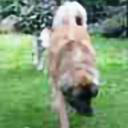

In [108]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [109]:
learn_gen=None
gc.collect()

20

Pretrain the critic on crappy vs not crappy.

In [110]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [111]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

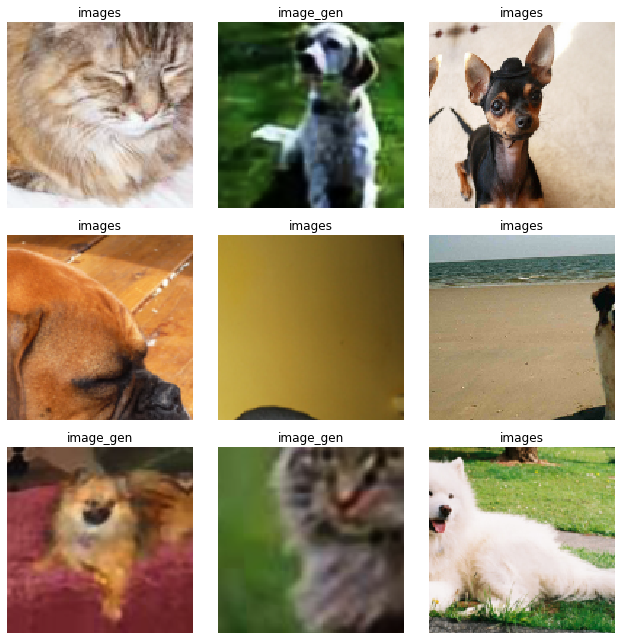

In [112]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [113]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [114]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

We're going to use binary cross entropy as usual. When you're doing a GAN, you need to be particularly careful that the generator and the critic can't both push in the same direction and increase the weights out of control. So we have to use something called spectral normalization to make GANs work nowadays.

In [115]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

Anyway, if you say `gan_critic`, fast.ai will give you a binary classifier suitable for GANs.

In [130]:
#learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.573616,0.638825,0.685983,01:35
1,0.300991,0.448494,0.826895,01:34
2,0.112386,0.509518,0.785356,01:34
3,0.088916,0.042092,0.991083,01:35
4,0.041400,0.056591,0.983333,01:34
5,0.049662,0.074549,0.976923,01:35


In [131]:
#learn_critic.save('critic-pre2')

In [116]:
learn_critic.load('critic-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
image_gen,image_gen,image_gen,image_gen,image_gen
Path: /home/trondheim/.fastai/data/oxford-iiit-pet;

Valid: LabelList (1404 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,image_gen,images
Path: /home/trondheim/.fastai/data/oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.075, inplace=False)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequenti

## GAN

Let's finish up this GAN. Now that we have pre-trained the generator and pre-trained the critic. 
* We now need to get it to kind of ping pong between training a little bit of each. The amount of time you spend on each of those things and the learning rates you use is still a little bit on the fuzzy side, so we've created a `GANLearner` for you which you just pass in your generator and your critic (which we've just simply loaded here from the ones we just trained) and it will go ahead and when you go `learn.fit`,. 
* it will do that for you - it'll figure out how much time to train generator and then when to switch to training the discriminator/critic and it'll go backward and forward.

In [133]:
learn_crit=None
learn_gen=None
gc.collect()

94

In [134]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [135]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [136]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [137]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [138]:
lr = 1e-4

In [139]:
learn.fit(40,lr)

One of the tough things about GANs is that these loss numbers, they're meaningless. You can't expect them to go down because as the generator gets better, it gets harder for the discriminator (i.e. the critic) and then as the critic gets better, it's harder for the generator. So the numbers should stay about the same.So that's one of the tough things about training GANs is it's hard to know how are they doing. The only way to know how are they doing is to actually take a look at the results from time to time. If you put show_img=True here:

In [141]:
learn.save('gan-1c')

In [142]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [ ]:
learn.save('gan-2c')

In [132]:
learn.show_results(rows=16)

AttributeError: 'GANLearner' object has no attribute 'gen_mode'